In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# For LR feature‐building
import joblib
from scipy import sparse
from gensim import corpora
from gensim.models import LdaModel

# For LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# For BERT
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForSequenceClassification

# Common metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix
)

# Ensure reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)


In [6]:
# External data path
REAL_CSV  = "../data/external/True.csv"
FAKE_CSV  = "../data/external/Fake.csv"

In [7]:
# Load external CSV and combine into a single dataframe
real_news = pd.read_csv(REAL_CSV)
real_news["is_fake"] = 0

fake_news = pd.read_csv(FAKE_CSV)
fake_news["is_fake"] = 1

# Keep only the required columns
real_news = real_news[["title", "text", "is_fake"]]
fake_news = fake_news[["title", "text", "is_fake"]]

# Combine and shuffle the external dataframe
external = pd.concat([real_news, fake_news], ignore_index=True)
external = external.sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Combined external shape:", external.shape)

external.head()

Combined external shape: (44898, 3)


,title,text,is_fake
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,1


In [8]:
from src.utils import basic_clean, preprocess_text

external["raw_text"] = external["title"].astype(str) + " " + external["text"].astype(str)
external["clean_text"] = external["raw_text"].apply(basic_clean)
external["processed_text"] = external["clean_text"].apply(preprocess_text)
external["is_fake"] = external["is_fake"].astype(int)

# Clean the external data
external.dropna(inplace=True)
external.drop_duplicates(inplace=True)
external.reset_index(drop=True, inplace=True)
external.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39105 entries, 0 to 39104
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           39105 non-null  object
 1   text            39105 non-null  object
 2   is_fake         39105 non-null  int32 
 3   raw_text        39105 non-null  object
 4   clean_text      39105 non-null  object
 5   processed_text  39105 non-null  object
dtypes: int32(1), object(5)
memory usage: 1.6+ MB


## Logistic Regression: Feature Construction & Evaluation

In [9]:
# 3.1 Load saved LR artifacts
LOGREG_DIR    = "../models/log_reg/"

tfidf      = joblib.load(LOGREG_DIR + "tfidf_vectorizer.joblib")
scaler     = joblib.load(LOGREG_DIR + "scaler.joblib")
lda_dict   = corpora.Dictionary.load(str(LOGREG_DIR + "lda_dictionary.dict"))
lda_model  = LdaModel.load(str(LOGREG_DIR + "lda_model.model"))
lr_model   = joblib.load(LOGREG_DIR + "logreg_model.joblib")

print("Loaded all Logistic Regression artifacts.")

Loaded all Logistic Regression artifacts.


In [10]:
# 3.2 Numeric features (same columns as during training)
from src.utils import get_features

feat_cols = ["word_count", "char_count", "avg_word_length",
             "polarity", "subjectivity", "reading_ease", "smog_index"]

ext_feats_df = get_features(external)[feat_cols]
X_ext_feats = scaler.transform(ext_feats_df)  # shape (n_ext, 7)
print("Numeric features shape:", X_ext_feats.shape)

Numeric features shape: (39105, 7)


In [11]:
# 3.3 TF–IDF features on clean_text
X_ext_tfidf = tfidf.transform(external["clean_text"])
print("TF–IDF shape:", X_ext_tfidf.shape)

TF–IDF shape: (39105, 5000)


In [12]:
# 3.4 LDA topic distributions
def get_topic_dist(model, bow_corpus, num_topics):
    arr = np.zeros((len(bow_corpus), num_topics), dtype=np.float32)
    for i, bow in enumerate(bow_corpus):
        for topic_id, prob in model.get_document_topics(bow, minimum_probability=0.0):
            arr[i, topic_id] = prob
    return arr

processed_ext = [txt.split() for txt in external["processed_text"]]
bow_ext = [lda_dict.doc2bow(text) for text in processed_ext]
num_topics = lda_model.num_topics

X_ext_lda = get_topic_dist(lda_model, bow_ext, num_topics)
print("LDA distribution shape:", X_ext_lda.shape)

LDA distribution shape: (39105, 24)


In [13]:
# 3.5 Combine all features into a sparse matrix

if np.isnan(X_ext_feats).any():
    X_ext_feats = np.nan_to_num(X_ext_feats, nan=0.0)
    
X_ext_lr = sparse.hstack([
    X_ext_tfidf,
    sparse.csr_matrix(X_ext_lda),
    sparse.csr_matrix(X_ext_feats)
])
y_ext = external["is_fake"].values
print("Combined feature matrix shape for LR:", X_ext_lr.shape)

Combined feature matrix shape for LR: (39105, 5031)



=== Logistic Regression External Validation ===
              precision    recall  f1-score   support

        real       0.99      1.00      0.99     21197
        fake       0.99      0.98      0.99     17908

    accuracy                           0.99     39105
   macro avg       0.99      0.99      0.99     39105
weighted avg       0.99      0.99      0.99     39105

ROC‐AUC (LR) on external data: 0.9993


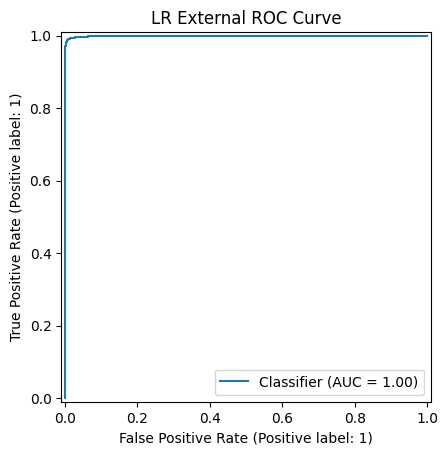

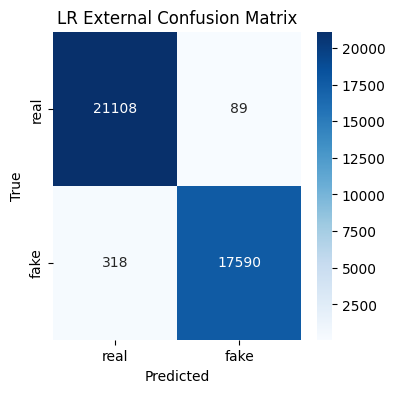

In [14]:
# 3.6.1 Predict & get probabilities
y_ext_pred = lr_model.predict(X_ext_lr)
y_ext_prob = lr_model.predict_proba(X_ext_lr)[:, 1]

# 3.6.2 Classification report
print("\n=== Logistic Regression External Validation ===")
print(classification_report(y_ext, y_ext_pred, target_names=["real","fake"]))

# 3.6.3 ROC‐AUC
auc_ext = roc_auc_score(y_ext, y_ext_prob)
print(f"ROC‐AUC (LR) on external data: {auc_ext:.4f}")

# 3.6.4 ROC curve
RocCurveDisplay.from_predictions(y_ext, y_ext_prob)
plt.title("LR External ROC Curve")
plt.show()

# 3.6.5 Confusion Matrix
cm = confusion_matrix(y_ext, y_ext_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["real","fake"],
            yticklabels=["real","fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LR External Confusion Matrix")
plt.show()

## LSTM: Tokenization & Evaluation

In [15]:
LSTM_DIR    = "../models/lstm/"

MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 200

def texts_to_padded_sequences(texts, tokenizer, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen,
                           padding='post', truncating='post')
    return padded

tokenizer = joblib.load(LSTM_DIR + "tokenizer.pkl")

X_ext_seq = texts_to_padded_sequences(external["clean_text"].values,
                                       tokenizer,
                                       MAX_SEQUENCE_LENGTH)
print("External sequences shape:", X_ext_seq.shape)

External sequences shape: (39105, 200)


1223/1223 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step
--- External Results ---
              precision    recall  f1-score   support

        real       0.98      1.00      0.99     21197
        fake       1.00      0.97      0.99     17908

    accuracy                           0.99     39105
   macro avg       0.99      0.99      0.99     39105
weighted avg       0.99      0.99      0.99     39105

ROC-AUC: 0.9994



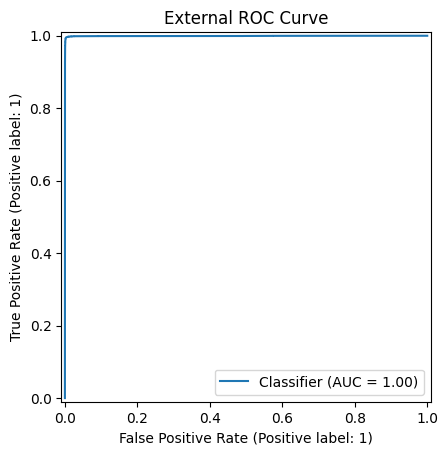

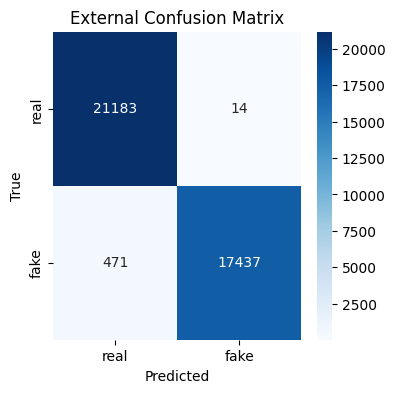

In [17]:
from src.plot import plot_lstm_evaluation

def load_lstm_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"LSTM model file not found: {model_path}")
    return load_model(model_path)

best_lstm = load_model(LSTM_DIR + "final_lstm.keras", compile=False)
plot_lstm_evaluation("External", best_lstm, X_ext_seq, y_ext)

## BERT – Tokenization & Evaluation

#TODO: move it from 3.3-BERT.ipynb notebook